In [1]:
#@title Import packages

!pip install sacremoses

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import os
import pandas as pd
import sacremoses
from torch.utils.data import dataloader, Dataset
import tqdm

In [0]:
import matplotlib.pyplot as plt

**Portions of this lab taken from DS-GA-1011, Fall 2018**

## 1. Tensor basics

PyTorch is a library for training deep neural networks, and much of it is based on the `Tensor`, an array type that is similar to NumPy arrays.

In [3]:
tensor = torch.Tensor([0, 1, 2, 3])
tensor

tensor([0., 1., 2., 3.])

In [4]:
print(tensor.shape)
print(tensor.dtype)

torch.Size([4])
torch.float32


It's easy to convert between NumPy arrays PyTorch Tensors.

In [5]:
tensor.numpy()

array([0., 1., 2., 3.], dtype=float32)

They also behave a lot like NumPy arrays.

In [6]:
tensor * 5

tensor([ 0.,  5., 10., 15.])

## 2. Using CUDA

CUDA and cuDNN allow you to use GPUs to accerate computations for mathematical operations and neural network models.

PyTorch natively supports this.

In [0]:
assert torch.cuda.is_available and torch.has_cudnn

In [0]:
x = torch.Tensor(range(5))
y = torch.Tensor(np.ones(5))

In [9]:
x.cuda()

tensor([0., 1., 2., 3., 4.], device='cuda:0')

In [10]:
z = x.cuda() + y.cuda()
print(z)

tensor([1., 2., 3., 4., 5.], device='cuda:0')


In [11]:
z.cpu()

tensor([1., 2., 3., 4., 5.])

The recommended method is to use torch.device() as follows,

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
z = x.to(device) + y.to(device)
print(z)

tensor([1., 2., 3., 4., 5.], device='cuda:0')


## 3. Autograd

Autograd is a submodule in PyTorch that handles automatic differentiations and gradient computation. This allows you to simply define a model once, in a forward fashion, and the library handles the computation of all gradients in the computational graph.

Here, we create 2 Tensors, but we want PyTorch to compute gradients with respect to x
. By default, for arbitrary computations in PyTorch, no gradiens are computed (e.g for y).

In [0]:
x = torch.randn(5, requires_grad=True)
y = torch.arange(5.)

In [14]:
print("tensor x: ", x)
print("gradient wrt x:", x.grad)

tensor x:  tensor([-2.8157, -1.5841,  0.4311,  0.2688, -0.5965], requires_grad=True)
gradient wrt x: None


In [15]:
print(y)
print(y.grad)

tensor([0., 1., 2., 3., 4.])
None


We defined $z = x \cdot y$. Then

$$\frac{dz}{dx} = y$$

Note `z.grad_fn`, which shows $z$ was computed, capturing its dependencies in the computation graph.

In [16]:
z = (x * y).sum()
print(z)
print(z.grad)
print(z.grad_fn)

tensor(-2.3017, grad_fn=<SumBackward0>)
None


At this point, no gradients are computed yet. It is only when we call z.backward() that PyTorch computes the gradients, and backpropagates them to any node in the graph that required gradients (e.g. x).

In [0]:
z.backward()

As we can see, $x$ now has gradients associated with it, but $y$ does not.

In [18]:
print(x.grad)
print(y.grad)
print(z.grad)

tensor([0., 1., 2., 3., 4.])
None
None


With just this, we can compute a very rudimentary form of gradient descent!


In [0]:
# A very silly case of gradient descent:
learning_rate = 0.01
x = torch.tensor([1000.], requires_grad=True)
x_values = []
for i in range(1000):
    
    # Our loss function is: We want x**2 to be small
    loss = x ** 2
    loss.backward()
    
    # Have to do something a little convoluted here to subtract the 
    #   gradient -- don't worry, we'll never do this again
    x.data.sub_(x.grad.data * learning_rate)
    
    # Remember to zero-out the gradient! 
    # PyTorch doesn't do it automatically.
    x.grad.data = torch.Tensor([0])
    x_values.append(x.item())

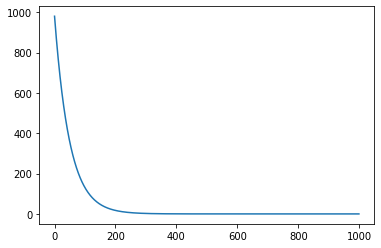

In [20]:
plt.plot(x_values)

Lastly, sometimes you want to run things without computing gradients:

In [21]:
x = torch.tensor([1000.], requires_grad=True)

# With gradient computation:
loss = x ** 2
print(loss.requires_grad)


# Without gradient computation:
with torch.no_grad(): # This temporarily sets all the requires_grad flags to false
    loss = x ** 2
print(loss.requires_grad)

True
False


## 4. Regression with PyTorch

Let's solve a toy regression problem with PyTorch. Let's define the following data-generating process:

$$ y = wx + b + \epsilon$$

Where $w=2$, $b=5$, and $\epsilon \sim N(0, 1)$.

In [0]:
rng = np.random.RandomState(seed=1234)
torch.manual_seed(1234)
x = rng.uniform(0, 10, 100)
w = 2
b = 5
eps = rng.normal(size=100)
y = w * x + b + eps

Our data looks like this. Now, we want to fit a best-fit line through our data.

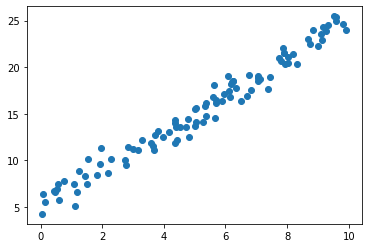

In [23]:
plt.scatter(x, y)

PyTorch lets users wrap complex function in `nn.Modules`. `nn.Linear` is a simple instance of a module, that just captures a simple linear function.

In [0]:
linear_model = nn.Linear(in_features=1, out_features=1)

The above initialized `linear_model` contains two parameters: a weight and a bias, corresponding to the $w$ and $b$ above. The values of these parameters are randomly initialized at the start.

In [25]:
for name, param in linear_model.named_parameters():
    print(name, param)

weight Parameter containing:
tensor([[-0.9420]], requires_grad=True)
bias Parameter containing:
tensor([-0.1962], requires_grad=True)


This is what our untrained model looks like initially: it's just a random line!

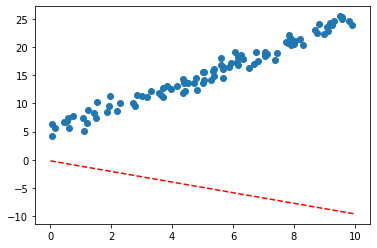

In [26]:
plt.scatter(x, y)
x_space = np.linspace(0, 10, 5)
plt.plot(
    x_space, 
    linear_model.weight.item() * x_space + linear_model.bias.item(),
    linestyle="--", color="red"
)

To start training, we'll do two things:
* First, we'll create PyTorch tensors based on our artifically generated data.
* Second, we'll create an optimizer, that will make gradient descent more convenient for us. We'll use a simple stochastic gradient descent (SGD) optimizer with a learning rate of 0.01.

In [0]:
x_tensor = torch.tensor(x).float().view(-1, 1)
y_tensor = torch.tensor(y).float().view(-1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=0.01)

Let's perform our optimization for 1000 steps, and see how our line of best fit changes over time (we'll check every 200 steps).

Pay close attention to the steps that happen within the loop:

1. Compute the forward pass (predict $\hat{y}$)
2. Compute the loss (how far are we from the true $y$?)
3. Back-propagate the gradients
4. Take a step with the optimizer (update the parameters)
5. Zero-out the gradients of the optimizer (**This is an important and often forgotten step**. If you don't do this, the gradients will be continually accumulated for past forward passes.)

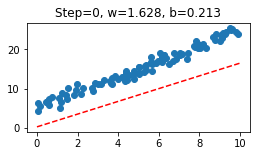

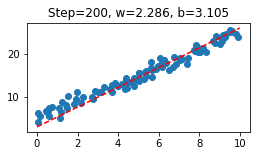

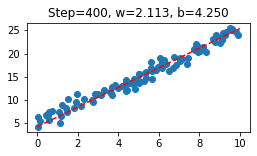

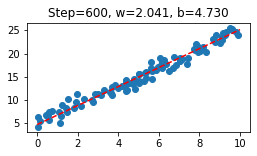

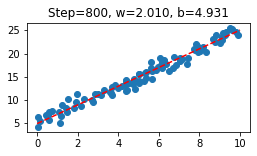

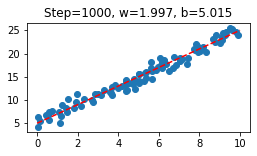

In [28]:
for t in range(1001):
    # === Optimization === #
    
    # 1. Compute the forward pass
    y_hat = linear_model(x_tensor)
    
    # 2. Compute the loss
    loss = F.mse_loss(y_hat, y_tensor)
    
    # 3. Back-propagate the gradients
    loss.backward()
    
    # 4. Take a step with the optimizer (update the parameters)
    optimizer.step()
    
    # 5.Zero-out the gradients of the optimizer
    optimizer.zero_grad()
    
    # === Plotting === #
    if t % 200 == 0:
        current_w = linear_model.weight.item()
        current_b = linear_model.bias.item()
        plt.figure(figsize=(4, 2))
        plt.scatter(x, y)
        x_space = np.linspace(0, 10, 5)
        plt.plot(
            x_space, 
            current_w * x_space + current_b,
            linestyle="--", color="red"
        )
        plt.title(f"Step={t}, w={current_w:.3f}, b={current_b:.3f}")
        plt.show()

You should see the values of $w$ and $b$ get closer to $2$ and $5$ respectively.

## A simple text-classification model with PyTorch

In [29]:
#@title Download data and GloVe word embeddings

# === Download data and GloVe word embeddings
# !wget https://s3.amazonaws.com/fast-ai-nlp/yelp_review_polarity_csv.tgz
# !wget http://nlp.stanford.edu/data/glove.6B.zip

# === Unzip yelp dataset and use a truncated version of the dataset
# !tar zxvf yelp_review_polarity_csv.tgz
# !head -n 10000 yelp_review_polarity_csv/train.csv > train_10000.csv
# !head -n 1000 yelp_review_polarity_csv/test.csv > test_1000.csv

# === Unzip word embeddings and use only the top 50000 word embeddings for speed
# !unzip glove.6B.zip
# !head -n 50000 glove.6B.300d.txt > glove.6B.300d__50k.txt

# === Download Preprocessed version
!wget https://docs.google.com/uc?id=1iBc6Mc8rt1T9Uo6QH9rdVQOL6ZjwvTGf -O train_10000.csv
!wget https://docs.google.com/uc?id=13B-BqMHTyUehUZkyNBaHYByCjGUUZXwd -O test_1000.csv
!wget https://docs.google.com/uc?id=1KMJTagaVD9hFHXFTPtNk0u2JjvNlyCAu -O glove_split.aa
!wget https://docs.google.com/uc?id=1LF2yD2jToXriyD-lsYA5hj03f7J3ZKaY -O glove_split.ab
!wget https://docs.google.com/uc?id=1N1xnxkRyM5Gar7sv4d41alyTL92Iip3f -O glove_split.ac
!cat glove_split.?? > 'glove.6B.300d__50k.txt'

--2020-02-17 19:36:18--  https://docs.google.com/uc?id=1iBc6Mc8rt1T9Uo6QH9rdVQOL6ZjwvTGf
Resolving docs.google.com (docs.google.com)... 172.217.194.101, 172.217.194.113, 172.217.194.102, ...
Connecting to docs.google.com (docs.google.com)|172.217.194.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-10-0g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/l9agna6i9ush5dp69to8vr4la2783ala/1581967800000/14514704803973256873/*/1iBc6Mc8rt1T9Uo6QH9rdVQOL6ZjwvTGf [following]
--2020-02-17 19:36:19--  https://doc-10-0g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/l9agna6i9ush5dp69to8vr4la2783ala/1581967800000/14514704803973256873/*/1iBc6Mc8rt1T9Uo6QH9rdVQOL6ZjwvTGf
Resolving doc-10-0g-docs.googleusercontent.com (doc-10-0g-docs.googleusercontent.com)... 74.125.24.132, 2404:6800:4003:c03::84
Connecting to doc-10-0g-docs.googleusercontent.com (doc-10-0g-docs.googleusercontent.com)|74.125.2

In [0]:
# Some constants that will be useful along the way.

VOCAB_SIZE = 50001
EMBEDDING_DIM = 300
PAD_TOKEN = "PAD"
NUM_CLASSES = 2
NUM_EPOCHS = 10

First, let's read in some data. We'll work with a subset of the Yelp review classification dataset.

In [0]:
import pandas as pd
import numpy as np
train_df = pd.read_csv("train_10000.csv", header=None, names=["label", "text"])
test_df = pd.read_csv("test_1000.csv", header=None, names=["label", "text"])

In [32]:
train_df.head()

,label,text
0,1,"Unfortunately, the frustration of being Dr. Go..."
1,2,Been going to Dr. Goldberg for over 10 years. ...
2,1,I don't know what Dr. Goldberg was like before...
3,1,I'm writing this review to give you a heads up...
4,2,All the food is great here. But the best thing...


The labels correspond to 1 for negative and 2 for positive.

For this model, we're going to make use of word embeddings. Word embeddings map individual words or tokens to unique vector of numbers (e.g. 300-dim), corresponding to a point in high-dimensional space. (Why these are useful will be covered in class in the near future!)

We will use the [GloVe](https://nlp.stanford.edu/projects/glove/) word vectors as our embeddings. These are pretrained on a large corpus of text.

In [0]:
def load_glove(glove_path, embedding_dim):
    with open(glove_path) as f:
        token_ls = [PAD_TOKEN]
        embedding_ls = [np.zeros(embedding_dim)]
        for line in f:
            token, raw_embedding = line.split(maxsplit=1)
            token_ls.append(token)
            embedding = np.array([float(x) for x in raw_embedding.split()])
            embedding_ls.append(embedding)
        embeddings = np.array(embedding_ls)
    return token_ls, embeddings

In [0]:
glove_path = "glove.6B.300d__50k.txt"
vocab, embeddings = load_glove(glove_path, EMBEDDING_DIM)

After loading the GloVe vectors, we see that we have vocab of 50000 words and a unique PAD token, and a [50000$\times$300] NumPy array of word vectors.

In [35]:
print(len(vocab))
print(vocab[:20])
print(embeddings.shape)
print(embeddings[:5])

50001
['PAD', 'the', ',', '.', 'of', 'to', 'and', 'in', 'a', '"', "'s", 'for', '-', 'that', 'on', 'is', 'was', 'said', 'with', 'he']
(50001, 300)
[[ 0.         0.         0.        ...  0.         0.         0.       ]
 [ 0.04656    0.21318   -0.0074364 ...  0.0090611 -0.20989    0.053913 ]
 [-0.25539   -0.25723    0.13169   ... -0.2329    -0.12226    0.35499  ]
 [-0.12559    0.01363    0.10306   ... -0.34224   -0.022394   0.13684  ]
 [-0.076947  -0.021211   0.21271   ...  0.18351   -0.29183   -0.046533 ]]


Our strategy is to tokenize (break a string of text into words or tokens) our input string into a list of tokens, and map each word the the corresponding vector.

We do this by first mapping each word to a token-id, and then use a PyTorch `nn.Embedding` module that maps from token-ids to embeddings. The token-id will simply be the numerical position in our `vocab`.

First, we'll write a function that converts our DataFrame of text and labels into an array of token-ids and an array of labels. We'll use a maximum sequence length of 128, and pad shorter inputs to that length. If we encounter a word that doesn't appear in our vocab, we'll also treat it as a padded value.

In [36]:
def featurize(data_df, tokenizer, vocab, max_seq_length=128):
    vocab_to_idx = {word: i for i, word in enumerate(vocab)}
    text_data = []
    label_data = []
    for row in tqdm.tqdm_notebook(data_df.itertuples(), total=len(data_df)):
        tokenized = tokenizer.tokenize(row.text.lower())
        if len(tokenized) < max_seq_length:
            tokenized += [PAD_TOKEN] * (max_seq_length - len(tokenized))
        tokenized = tokenized[:max_seq_length]
        ids = [vocab_to_idx.get(token, 0) for token in tokenized]
        text_data.append(ids)
        label_data.append(1 if row.label == 2 else 0)
    return np.array(text_data), np.array(label_data)

tokenizer = sacremoses.MosesTokenizer()
train_text, train_labels = featurize(train_df, tokenizer, vocab)
test_text, test_labels = featurize(test_df, tokenizer, vocab)

In [37]:
print("Train text shape:", train_text.shape)
print("Train labels shape:", train_labels.shape)
print("\nTrain text first 5 examples:\n", train_text[:5])
print("\nTrain labels first 5 examples:\n", train_labels[:5])

Train text shape: (10000, 128)
Train labels shape: (10000,)

Train text first 5 examples:
 [[ 4717     2     1  6429     4   135  1345 12316     0  3223    15     8
   5149     4     1  1222    42     0    41    18   101   110    69  1769
      7 16727    66   220  2083     2  5511     0    21  1349    13    27
    822  1482   333  5320     1     0    21  1141  1145   233   607     4
   3383  1526     5   170    30     0    39    32    80    11    13    47
   1026     5   436    18    21   189    42    34   308    76    38   748
     18   110    69  1769     6    42   121  3317     0   170     0    82
     34   284   538     2    82    34  1616    18   750  1076     2   739
      0     0  1545 10311     1  1265   189    21     0 29467     6    37
    162     1     0    21     0    18  6744    13    42   999    13    42
     34     5   456  1345 12316   233  1570     3]
 [   52   223     5  1345 12316    11    75   207     0    42   270    42
     16    49     4    27  2694  1616    62 

Next, we build the `nn.Embedding` module, and put our loaded GloVe vectors into the embeddding weights. (Since these are pretrained, we'll opt not to train them any more, so we set `requires_grad` to False.)

In [0]:
embedding_layer = nn.Embedding(VOCAB_SIZE, EMBEDDING_DIM, padding_idx=0)
embedding_layer.weight.data = torch.Tensor(embeddings).float()
embedding_layer.weight.requires_grad = False

Deep learning models are typically trained in batches of inputs (as opposed to the whole data set at once). We'll use some PyTorch utilities to easily create input batches. We'll use the `Dataset` and `Dataloader` objects for this.

In [0]:
class TextDataset(Dataset):
    def __init__(self, text_data, labels_data):
        super().__init__()
        self.text_data = text_data
        self.labels_data = labels_data
    
    def __len__(self):
        return len(self.text_data)
    
    def __getitem__(self, idx):
        return (self.text_data[idx], self.labels_data[idx])

In [0]:
train_dataset = TextDataset(train_text, train_labels)
test_dataset = TextDataset(test_text, test_labels)

The order of examples are often shuffled in training, but never for evaluation.

In [0]:
train_dataloader = dataloader.DataLoader(
    dataset=train_dataset, batch_size=256, shuffle=True
)
test_dataloader = dataloader.DataLoader(
    dataset=test_dataset, batch_size=256, shuffle=False
)

Finally, let's define our model. Our model will simply take an average our the embeddings for an input, and then use a apply a simple linear transformation to get the predicted probabilities for the two classes. This is essentially a multi-class logistic regression.

In [0]:
class BagOfWordsModel(nn.Module):
    def __init__(self, embedding_layer, num_classes):
        super().__init__()
        self.embedding_layer = embedding_layer
        self.out_layer = nn.Linear(embedding_layer.embedding_dim, num_classes)
        
    def forward(self, x):
        # Retrieve embedding vector for each token
        # Output dim: [batch_size, seq_length, embedding_dim]
        embedded = embedding_layer(x)
        
        # Compute the number of valid (non-padding, non-unknown) embeddings per exmaple
        # Output dim: [batch_size]
        num_embedded = (x != embedding_layer.padding_idx) \
            .float().sum(dim=1).clamp(1)
        
        # Average the embeddings for each example
        # Output dim: [batch_size, embedding_dim]
        averaged_embeddings = embedded.sum(dim=1) / num_embedded.view(-1, 1)
        
        # Put the embedding through a linear layer to get our score (logit)
        #   for each class
        # Output dim: [batch_size, num_classes]
        out = self.out_layer(averaged_embeddings)
        
        # Apply softmax to our logits to get probabilities
        # Output dim: [batch_size, num_classes]
        
        #return F.softmax(out, dim=-1)
        return out

### Putting it together

Now, let's prepare for training. We'll instantiate our model, and set up our loss function and optimizer.

(Take note of when we call `.to(device)` for the model and inputs.

In [43]:
torch.manual_seed(2345)

In [0]:
device = torch.device("cuda:0")
bow_model = BagOfWordsModel(embedding_layer, NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(bow_model.parameters(), lr=0.01)
loss_history = []

In [45]:
bow_model.train()  # this enables regularization, which we don't currently have
for epoch in tqdm.tqdm_notebook(range(NUM_EPOCHS)):
    for batch_text, batch_labels in train_dataloader:
        preds = bow_model(batch_text.to(device))
        loss = criterion(preds, batch_labels.to(device))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_history.append(loss.item())

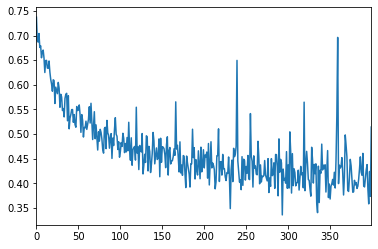

In [46]:
pd.Series(loss_history).plot()

Let's evaluate our model on the test set.

In [0]:
def run_inference(model, dataloader, labels, device):
    model.eval()
    with torch.no_grad():
        all_preds = []
        for batch_text, batch_labels in dataloader:
            preds = model(batch_text.to(device))
            all_preds.append(preds.detach().cpu().numpy())
    return np.concatenate(all_preds, axis=0)

In [48]:
preds = run_inference(bow_model, test_dataloader, test_labels, device)
(test_labels==preds.argmax(-1)).mean()

0.812

### A more complex model

We can make our model a little more complex. Let's add in:

1. A hidden layer (now the model is "deep"!)
2. Dropout (a form of regularization that randomly zeros out hidden activations during training)

In [0]:
class BetterBagOfWordsModel(nn.Module):
    def __init__(self, embedding_layer, num_classes,
                 hidden_dim=300, dropout_rate=0.5):
        super().__init__()
        self.embedding_layer = embedding_layer
        # ==== START === #
        # Consider using:
        #   nn.Dropout
        #   nn.Linear
        self.layer1 = nn.Linear(
            self.embedding_layer.embedding_dim,
            hidden_dim,
        )
        self.dropout = nn.Dropout(dropout_rate)
        # ==== END === #
        self.out_layer = nn.Linear(hidden_dim, num_classes)
        
    def forward(self, x):
        # Retrieve embedding vector for each token
        # Output dim: [batch_size, seq_length, embedding_dim]
        embedded = embedding_layer(x)
        
        # Compute the number of valid (non-padding, non-unknown) embeddings per exmaple
        # Output dim: [batch_size]
        num_embedded = (x != embedding_layer.padding_idx) \
            .float().sum(dim=1).clamp(1)
        
        # Average the embeddings for each example
        # Output dim: [batch_size, embedding_dim]
        averaged_embeddings = embedded.sum(dim=1) / num_embedded.view(-1, 1)
        
        # ==== START === #
        # Consider using:
        #   F.relu
        #   self.layer1
        #   self.dropout
        h = self.layer1(averaged_embeddings)
        h = self.dropout(h)
        # ==== END === #
        
        # Put the embedding through a linear layer to get our score (logit)
        #   for each class
        # Output dim: [batch_size, num_classes]
        out = self.out_layer(h)
        
        # Apply softmax to our logits to get probabilities
        # Output dim: [batch_size, num_classes]
        
        #return F.softmax(out, dim=-1)
        return out

In [0]:
device = torch.device("cuda:0")
better_bow_model = BetterBagOfWordsModel(
    embedding_layer, 
    NUM_CLASSES,
    hidden_dim=32,
).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(better_bow_model.parameters(), lr=0.01)
loss_history = []

In [51]:
better_bow_model.train()
for epoch in tqdm.tqdm_notebook(range(NUM_EPOCHS)):
    for batch_text, batch_labels in train_dataloader:
        preds = better_bow_model(batch_text.to(device))
        loss = criterion(preds, batch_labels.to(device))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_history.append(loss.item())

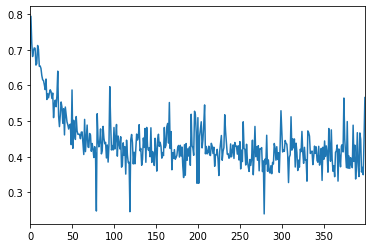

In [52]:
pd.Series(loss_history).plot()

In [53]:
preds = run_inference(better_bow_model, test_dataloader, test_labels, device)
(test_labels==preds.argmax(-1)).mean()

0.818

There's no guarantee that a more complex model works better!

Also, our current model is still pretty simple: it simply averages the word embeddings, and so it completely discards the word-order information. We will soon learn about modern deep learning models that address this.